# TopoDiff sample

#### This notebook aims to launch a generation of topologies by TopoDiff, with a set of constraints given as input. Three trained models are needed to sample from TopoDiff: the main diffusion model, the classifier and the regressor. To load the trained models, you must specify the location of the checkpoints (either downloaded or gotten from your own trainings).

In [ ]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import os
import pytorch_fid
import cv2
import sys

🚀 훈련 로그 분석 시작...
📊 발견된 메트릭들: ['grad_norm', 'lg_loss_scale', 'loss', 'mse', 'param_norm', 'samples', 'vb']
📈 총 280 스텝의 데이터


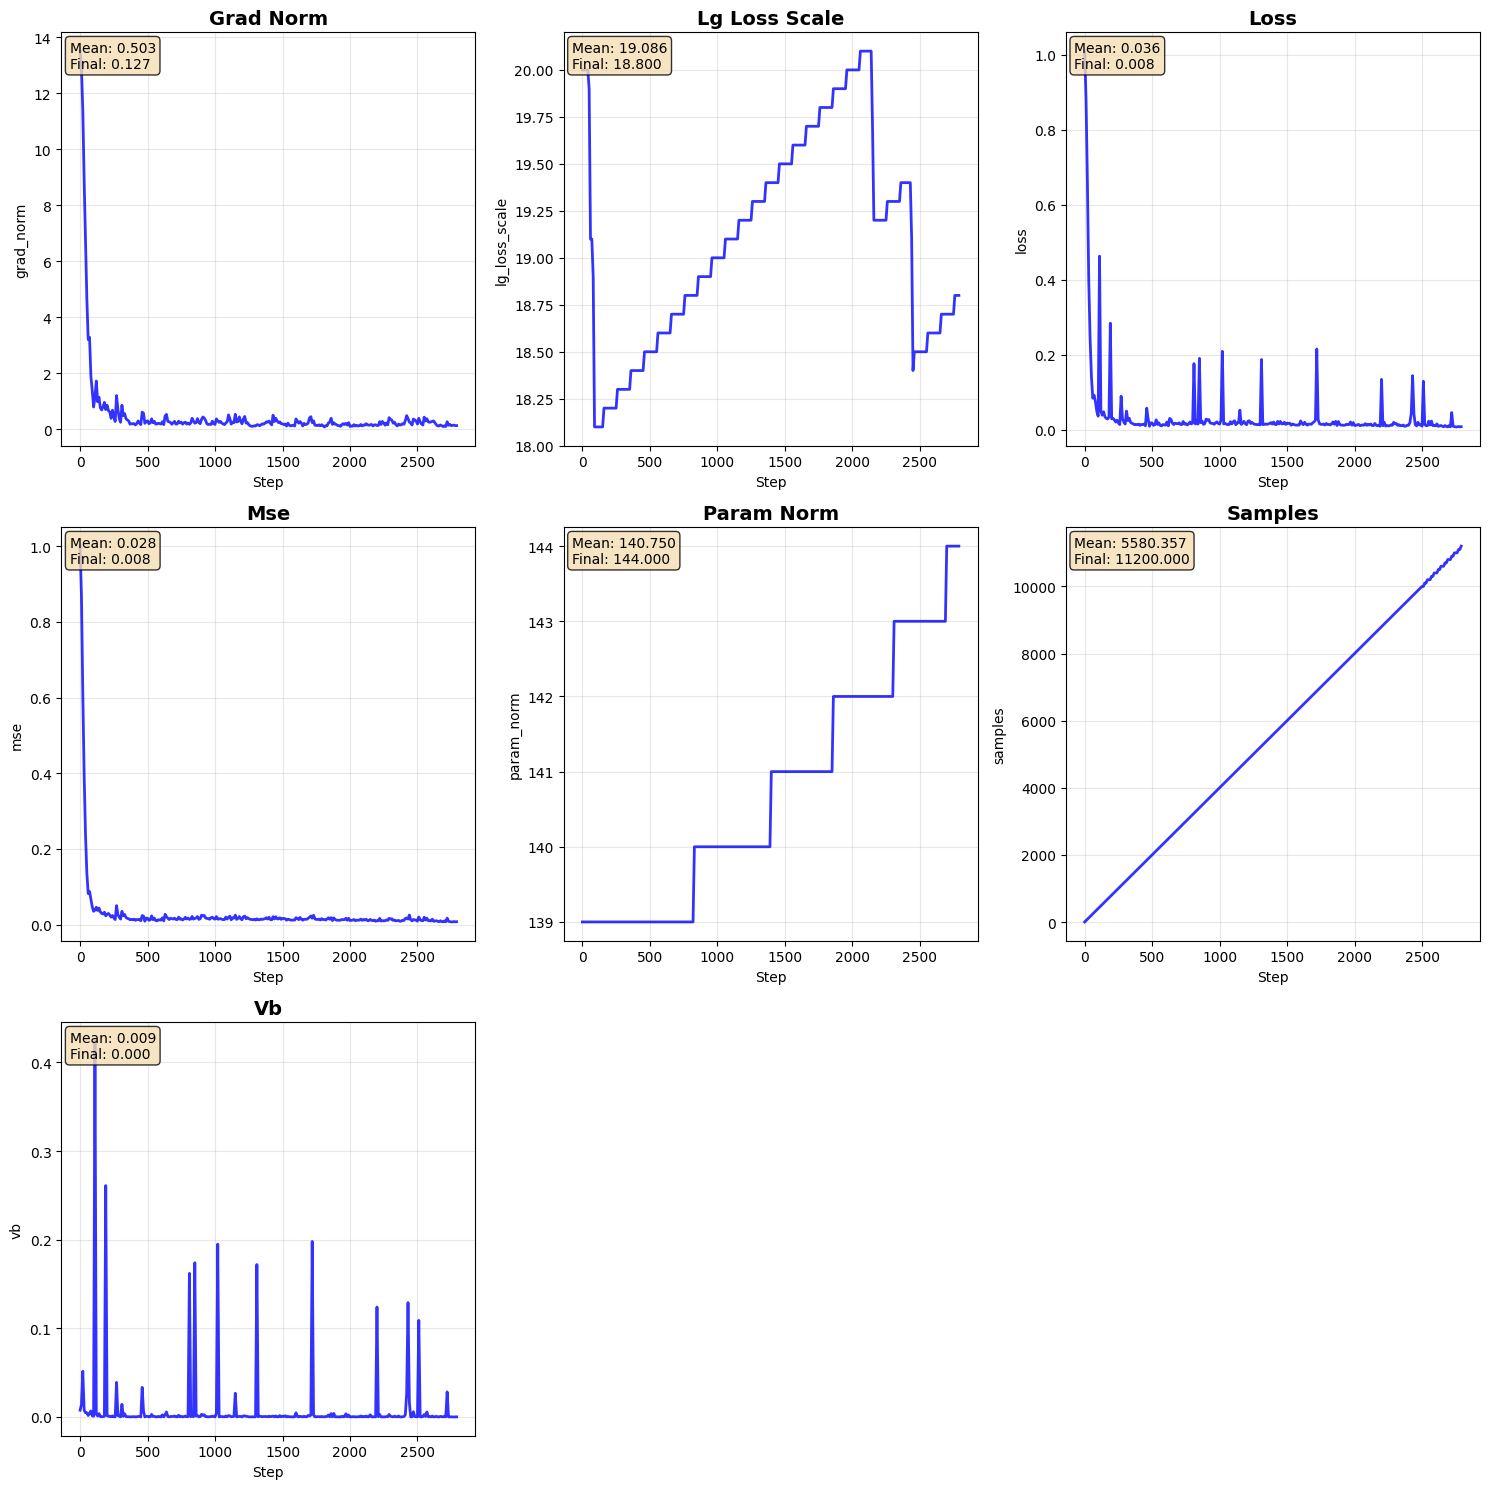


📋 훈련 요약:
----------------------------------------
grad_norm   :  13.5000 →   0.1270 ( -99.1%)
lg_loss_scale:  20.0000 →  18.8000 (  -6.0%)
loss        :   1.0100 →   0.0077 ( -99.2%)
mse         :   1.0000 →   0.0076 ( -99.2%)
param_norm  : 139.0000 → 144.0000 (  +3.6%)
samples     :   4.0000 → 11200.0000 (+279900.0%)
vb          :   0.0077 →   0.0001 ( -98.4%)

🔍 학습 상태 분석:
- 총 스텝: 280
- 초기 손실: 1.0100
- 현재 손실: 0.0077
- 최근 10스텝 트렌드: ⬇️ 감소 (-0.001337/step)
✅ 모델이 수렴하고 있습니다!


In [114]:
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import defaultdict

def parse_log_file(log_path):
    """로그 파일을 파싱해서 메트릭들을 추출"""
    metrics = defaultdict(list)
    
    with open(log_path, 'r') as f:
        content = f.read()
    
    # 로그 블록들을 찾기 (| key | value | 형태)
    log_blocks = re.findall(r'(?:\| \w+.*?\|.*?\|\n)+', content)
    
    for block in log_blocks:
        step_data = {}
        lines = block.strip().split('\n')
        
        for line in lines:
            # | key | value | 형태 파싱
            match = re.match(r'\|\s*(\w+)\s*\|\s*([0-9\.e\-\+]+)\s*\|', line)
            if match:
                key, value = match.groups()
                try:
                    step_data[key] = float(value)
                except ValueError:
                    step_data[key] = value
        
        # step이 있으면 해당 블록의 데이터 저장
        if 'step' in step_data:
            for key, value in step_data.items():
                metrics[key].append(value)
    
    return dict(metrics)

def plot_training_metrics(log_path):
    """훈련 메트릭들을 그래프로 시각화"""
    metrics = parse_log_file(log_path)
    
    if not metrics or 'step' not in metrics:
        print("❌ 로그 파일에서 step 정보를 찾을 수 없습니다.")
        return
    
    steps = metrics['step']
    
    # 사용 가능한 메트릭들 확인
    available_metrics = [k for k in metrics.keys() if k != 'step' and len(metrics[k]) == len(steps)]
    
    print(f"📊 발견된 메트릭들: {available_metrics}")
    print(f"📈 총 {len(steps)} 스텝의 데이터")
    
    # 서브플롯 개수 결정
    n_metrics = len(available_metrics)
    if n_metrics == 0:
        print("❌ 플롯할 메트릭이 없습니다.")
        return
    
    # 그리드 크기 계산
    n_cols = min(3, n_metrics)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 5*n_rows))
    
    for i, metric in enumerate(available_metrics, 1):
        plt.subplot(n_rows, n_cols, i)
        values = metrics[metric]
        
        plt.plot(steps, values, 'b-', linewidth=2, alpha=0.8)
        plt.title(f'{metric.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        plt.xlabel('Step')
        plt.ylabel(metric)
        plt.grid(True, alpha=0.3)
        
        # Y축 스케일 조정
        if metric in ['loss', 'vb'] and max(values) > 10:
            plt.yscale('log')
            plt.ylabel(f'{metric} (log scale)')
        
        # 통계 정보 표시
        mean_val = np.mean(values)
        final_val = values[-1] if values else 0
        plt.text(0.02, 0.98, f'Mean: {mean_val:.3f}\nFinal: {final_val:.3f}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 요약 통계
    print("\n📋 훈련 요약:")
    print("-" * 40)
    for metric in available_metrics:
        values = metrics[metric]
        if values:
            initial = values[0]
            final = values[-1]
            change = ((final - initial) / initial * 100) if initial != 0 else 0
            print(f"{metric:12}: {initial:8.4f} → {final:8.4f} ({change:+6.1f}%)")

def analyze_learning_progress(log_path):
    """학습 진행 상황 상세 분석"""
    metrics = parse_log_file(log_path)
    
    if 'loss' not in metrics or 'step' not in metrics:
        print("❌ loss 또는 step 정보가 없습니다.")
        return
    
    steps = np.array(metrics['step'])
    loss = np.array(metrics['loss'])
    
    # 학습 안정성 분석
    if len(loss) > 5:
        # 최근 손실의 변화율
        recent_steps = min(10, len(loss))
        recent_loss = loss[-recent_steps:]
        loss_trend = np.polyfit(range(recent_steps), recent_loss, 1)[0]
        
        print(f"\n🔍 학습 상태 분석:")
        print(f"- 총 스텝: {len(steps)}")
        print(f"- 초기 손실: {loss[0]:.4f}")
        print(f"- 현재 손실: {loss[-1]:.4f}")
        print(f"- 최근 {recent_steps}스텝 트렌드: {'⬇️ 감소' if loss_trend < 0 else '⬆️ 증가'} ({loss_trend:.6f}/step)")
        
        # 수렴 여부 판단
        if len(loss) > 20:
            recent_var = np.var(recent_loss)
            if recent_var < 0.1 and abs(loss_trend) < 0.01:
                print("✅ 모델이 수렴하고 있습니다!")
            elif loss_trend > 0.1:
                print("⚠️ 손실이 증가하고 있습니다. 학습률을 낮춰보세요.")
            else:
                print("🔄 모델이 계속 학습 중입니다.")

# 실행
if __name__ == "__main__":
    log_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/checkpoints/3d_diff_logdir_optimized_128/log.txt"
    
    print("🚀 훈련 로그 분석 시작...")
    plot_training_metrics(log_path)
    analyze_learning_progress(log_path)

In [7]:
import numpy as np

# Load the uploaded .npy file
meta_data_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/data/t0.2_dia0.1_fis0.1_iwp0.1_lid0.7_meta.npy"
meta_data = np.load(meta_data_path, allow_pickle=True)

# Inspect the content
meta_data_type = type(meta_data)
meta_data_summary = None

# If it's a dict-like object or structured array, inspect keys or dtype
if isinstance(meta_data, np.ndarray):
    if meta_data.dtype.names:  # structured array
        meta_data_summary = meta_data.dtype.names
    elif meta_data.shape == ():  # scalar object array (probably a dict)
        meta_data = meta_data.item()
        if isinstance(meta_data, dict):
            meta_data_summary = list(meta_data.keys())
    else:
        meta_data_summary = f"Regular ndarray, shape: {meta_data.shape}, dtype: {meta_data.dtype}"

meta_data_type, meta_data_summary
meta_values = meta_data.tolist()
meta_values


[0.4067840576171875, 251.2374725341797]

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPU 2 to use
import torch
print('CUDA_VISIBLE_DEVICES:', os.environ.get('CUDA_VISIBLE_DEVICES'))
print('PyTorch가 인식하는 GPU 개수:', torch.cuda.device_count())
print('현재 CUDA 장치 인덱스:', torch.cuda.current_device())
print('현재 CUDA 장치 이름:', torch.cuda.get_device_name(0))


CUDA_VISIBLE_DEVICES: 2
PyTorch가 인식하는 GPU 개수: 1
현재 CUDA 장치 인덱스: 0
현재 CUDA 장치 이름: NVIDIA RTX A6000


Logging to /home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized
Creating model and diffusion...
Model loaded from ./checkpoints/3d_diff_logdir_optimized_128/model003000.pt
Sampling 1 samples...
Starting sampling...


/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/topodiff/dist_util.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(io.BytesIO(data), **kwargs)
100%|████

Created 1 samples
Saving samples to /home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized
Sample 0: shape=(64, 64, 64), range=[nan, nan], mean=nan
Batch saved to /home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized/samples_batch.npz
Creating visualizations...



/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/scripts/topodiff_sample.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/yeoneung/miniconda3/envs/topodiff/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/yeoneung/miniconda3/envs/topodiff/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

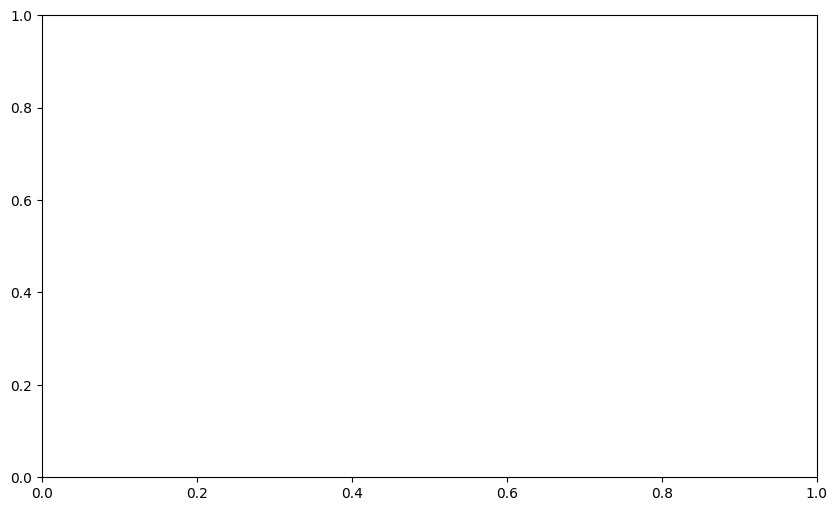

In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import os
os.environ['TOPODIFF_LOGDIR'] = '/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized'

MODEL_FLAGS = """
--image_size 64 
--num_channels 64 
--num_res_blocks 2 
--learn_sigma True 
--use_checkpoint True
--attention_resolutions 16,8
--channel_mult 1,2,3,4
--use_scale_shift_norm True
--dims 3
--in_channels 1
"""

DIFFUSION_FLAGS = """
--diffusion_steps 1000 
--timestep_respacing 1000
--noise_schedule cosine
--use_kl False
--predict_xstart False
"""

SAMPLE_FLAGS = """
--batch_size 1 
--num_samples 1
--use_fp16 True
--clip_denoised True
--use_ddim False
--visualize True
--num_visualize 1
"""

MODEL_PATH = "--model_path ./checkpoints/3d_diff_logdir_optimized_128/model003000.pt"


%run scripts/topodiff_sample.py $MODEL_FLAGS $DIFFUSION_FLAGS $SAMPLE_FLAGS $MODEL_PATH

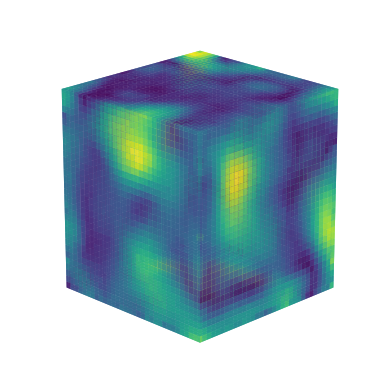

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def visualize_npz_cube_faces(npz_path, field_key='structure', show_plot=True):
    """NPZ 파일의 큐브 면 시각화 (정확한 면 연결)"""
    # NPZ 파일 로드
    data = np.load(npz_path)
    field = data[field_key]  # 예: shape = (64, 64, 64), 값 범위: -1 ~ 1
    if field.ndim != 3:
        raise ValueError("Expected 3D field data")

    res = field.shape[0]
    domain = np.linspace(-np.pi, np.pi, res)  # TPMS와 동일한 시각적 도메인 정렬
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(111, projection='3d')

    faces = {
        'zmin': field[:, :, 0],
        'zmax': field[:, :, -1],
        'ymin': field[:, 0, :],
        'ymax': field[:, -1, :],
        'xmin': field[0, :, :],
        'xmax': field[-1, :, :],
    }

    for face_name, face_data in faces.items():
        # 면 좌표 구성
        if face_name in ['zmin', 'zmax']:
            X, Y = np.meshgrid(domain, domain, indexing='ij')
            Z = np.full_like(X, domain[0] if face_name == 'zmin' else domain[-1])
        elif face_name in ['ymin', 'ymax']:
            X, Z = np.meshgrid(domain, domain, indexing='ij')
            Y = np.full_like(X, domain[0] if face_name == 'ymin' else domain[-1])
        else:
            Y, Z = np.meshgrid(domain, domain, indexing='ij')
            X = np.full_like(Y, domain[0] if face_name == 'xmin' else domain[-1])

        # face_data는 2D이므로 normalize 후 컬러맵 적용
        norm_vals = (face_data - face_data.min()) / (face_data.max() - face_data.min() + 1e-8)
        facecolors = cm.viridis(norm_vals)

        ax.plot_surface(X, Y, Z, facecolors=facecolors, alpha=0.85, shade=False, linewidth=0)

    # 보기 좋은 각도 설정
    ax.view_init(elev=20, azim=45)
    ax.set_box_aspect([1, 1, 1])
    ax.axis('off')
    plt.tight_layout()

    if show_plot:
        plt.show()

def visualize_npz_voxel_blocks(npz_path, field_key='structure', threshold=0.0, show_plot=True, subsample_factor=3):
    """NPZ 파일의 복셀 블록 시각화"""
    # NPZ 파일 로드
    data = np.load(npz_path)
    field = data[field_key]
    
    # 임계값으로 이진화
    voxel_data = field < threshold
    
    # 서브샘플링 및 플립 적용 (TPMS 스타일)
    voxel_sub = voxel_data[::subsample_factor, ::subsample_factor, ::subsample_factor]
    voxel_sub = np.flip(np.flip(np.flip(voxel_sub, axis=0), axis=1), axis=2)
    
    fig = plt.figure(figsize=(15, 5))
    
    # 첫 번째 뷰: 솔리드만
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.voxels(voxel_sub, facecolors='mediumseagreen', edgecolors='darkgreen', alpha=0.7)
    ax1.view_init(elev=20, azim=45)
    ax1.set_box_aspect([1, 1, 1])
    ax1.axis('off')
    ax1.set_title('Solid Blocks')
    
    # 두 번째 뷰: 솔리드 + 빈 공간
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.voxels(voxel_sub, facecolors='mediumseagreen', edgecolors='darkgreen', alpha=0.7)
    empty = ~voxel_sub
    ax2.voxels(empty, facecolors='lightgray', edgecolors='gray', alpha=0.15)
    ax2.view_init(elev=20, azim=45)
    ax2.set_box_aspect([1, 1, 1])
    ax2.axis('off')
    ax2.set_title('Solid + Empty Space')
    
    plt.tight_layout()
    if show_plot:
        plt.show()

def visualize_npz_complete(npz_path, field_key='structure', threshold=0.0, subsample_factor=3, show_plot=True):
    """NPZ 파일의 완전한 시각화: 큐브 면 + 복셀"""
    # NPZ 파일 로드
    data = np.load(npz_path)
    field = data[field_key]
    if field.ndim != 3:
        raise ValueError("Expected 3D field data")

    res = field.shape[0]
    domain = np.linspace(-np.pi, np.pi, res)
    
    fig = plt.figure(figsize=(20, 5))
    
    # 1. 큐브 면 시각화
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_title('Cube Faces (Original Data)')
    
    faces = {
        'zmin': field[:, :, 0],
        'zmax': field[:, :, -1],
        'ymin': field[:, 0, :],
        'ymax': field[:, -1, :],
        'xmin': field[0, :, :],
        'xmax': field[-1, :, :],
    }

    for face_name, face_data in faces.items():
        if face_name in ['zmin', 'zmax']:
            X, Y = np.meshgrid(domain, domain, indexing='ij')
            Z = np.full_like(X, domain[0] if face_name == 'zmin' else domain[-1])
        elif face_name in ['ymin', 'ymax']:
            X, Z = np.meshgrid(domain, domain, indexing='ij')
            Y = np.full_like(X, domain[0] if face_name == 'ymin' else domain[-1])
        else:
            Y, Z = np.meshgrid(domain, domain, indexing='ij')
            X = np.full_like(Y, domain[0] if face_name == 'xmin' else domain[-1])

        norm_vals = (face_data - face_data.min()) / (face_data.max() - face_data.min() + 1e-8)
        facecolors = cm.viridis(norm_vals)
        ax1.plot_surface(X, Y, Z, facecolors=facecolors, alpha=0.85, shade=False, linewidth=0)

    # 2. 복셀 시각화 (솔리드만)
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.set_title('Voxel Blocks (Solid)')
    
    voxel_data = field < threshold
    voxel_sub = voxel_data[::subsample_factor, ::subsample_factor, ::subsample_factor]
    #voxel_sub = np.flip(np.flip(np.flip(voxel_sub, axis=0), axis=1), axis=2)
    ax2.voxels(voxel_sub, facecolors='mediumseagreen', edgecolors='darkgreen', alpha=0.7)
    
    # 3. 복셀 시각화 (솔리드 + 빈 공간)
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.set_title('Voxel Blocks (Solid + Empty)')
    
    ax3.voxels(voxel_sub, facecolors='mediumseagreen', edgecolors='darkgreen', alpha=0.7)
    empty = ~voxel_sub
    ax3.voxels(empty, facecolors='lightgray', edgecolors='gray', alpha=0.15)
    
    # 모든 축에 동일한 뷰 적용
    for ax in [ax1, ax2, ax3]:
        ax.view_init(elev=20, azim=45)
        ax.set_box_aspect([1, 1, 1])
        ax.axis('off')
    
    plt.tight_layout()
    if show_plot:
        plt.show()

def visualize_npz_threshold_comparison(npz_path, field_key='structure', thresholds=[0.0, 0.2, -0.2], subsample_factor=3, show_plot=True):
    """다양한 임계값으로 복셀 시각화 비교"""
    data = np.load(npz_path)
    field = data[field_key]
    
    fig = plt.figure(figsize=(18, 6))
    
    for i, threshold in enumerate(thresholds):
        ax = fig.add_subplot(2, len(thresholds), i+1, projection='3d')
        ax.set_title(f'Threshold = {threshold}')
        
        voxel_data = field < threshold
        voxel_sub = voxel_data[::subsample_factor, ::subsample_factor, ::subsample_factor]
        #voxel_sub = np.flip(np.flip(np.flip(voxel_sub, axis=0), axis=1), axis=2)
        
        ax.voxels(voxel_sub, facecolors='mediumseagreen', edgecolors='darkgreen', alpha=0.7)
        ax.view_init(elev=20, azim=45)
        ax.set_box_aspect([1, 1, 1])
        ax.axis('off')
        
        # 하단: 솔리드 + 빈 공간
        ax_bottom = fig.add_subplot(2, len(thresholds), i+1+len(thresholds), projection='3d')
        ax_bottom.set_title(f'With Empty (Threshold = {threshold})')
        
        ax_bottom.voxels(voxel_sub, facecolors='mediumseagreen', edgecolors='darkgreen', alpha=0.7)
        empty = ~voxel_sub
        ax_bottom.voxels(empty, facecolors='lightgray', edgecolors='gray', alpha=0.15)
        ax_bottom.view_init(elev=20, azim=45)
        ax_bottom.set_box_aspect([1, 1, 1])
        ax_bottom.axis('off')
    
    plt.tight_layout()
    if show_plot:
        plt.show()

# 사용 예시
npz_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized/sample_0099.npz"

# 1. 기본 큐브 면 시각화 (정확한 면 연결)
visualize_npz_cube_faces(npz_path, field_key='volume')

# 2. 복셀 블록 시각화
#visualize_npz_voxel_blocks(npz_path, field_key='volume', threshold=-0.1)

# 3. 완전한 통합 시각화
#visualize_npz_complete(npz_path, field_key='volume', threshold=-0.2)

# 4. 다양한 임계값 비교
#visualize_npz_threshold_comparison(npz_path, field_key='volume', thresholds=[0.0, 0.2, -0.2])


In [1]:
import os

npz_dir = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized"

for i in range(100):
    filename = f"sample_{i:04d}.npz"
    npz_path = os.path.join(npz_dir, filename)
    if not os.path.exists(npz_path):
        print(f"{npz_path} not found, skipping.")
        continue
    print(f"시각화: {npz_path}")
    try:
        visualize_npz_cube_faces(npz_path, field_key='volume', show_plot=True)
        visualize_npz_voxel_blocks(npz_path, field_key='volume', threshold=-0.1, show_plot=True)
        visualize_npz_complete(npz_path, field_key='volume', threshold=-0.2, show_plot=True)
        visualize_npz_threshold_comparison(npz_path, field_key='volume', thresholds=[0.0, 0.2, -0.2], show_plot=True)
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        continue

print("모든 샘플 시각화 완료.")


시각화: /home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized/sample_0000.npz
Error processing sample_0000.npz: name 'visualize_npz_cube_faces' is not defined
시각화: /home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized/sample_0001.npz
Error processing sample_0001.npz: name 'visualize_npz_cube_faces' is not defined
시각화: /home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized/sample_0002.npz
Error processing sample_0002.npz: name 'visualize_npz_cube_faces' is not defined
시각화: /home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized/sample_0003.npz
Error processing sample_0003.npz: name 'visualize_npz_cube_faces' is not defined
시각화: /home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized/sample_0004.npz
Error processing sample_0004.npz: name 'visualize_npz_cube_faces' is not defined
시각화: /home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized/sampl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def visualize_npz_cube_faces(npz_path, field_key='structure', show_plot=True):
    # NPZ 파일 로드
    data = np.load(npz_path)
    field = data[field_key]  # 예: shape = (64, 64, 64), 값 범위: -1 ~ 1
    if field.ndim != 3:
        raise ValueError("Expected 3D field data")

    res = field.shape[0]
    domain = np.linspace(-np.pi, np.pi, res)  # TPMS와 동일한 시각적 도메인 정렬
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(111, projection='3d')

    faces = {
        'zmin': field[:, :, 0],
        'zmax': field[:, :, -1],
        'ymin': field[:, 0, :],
        'ymax': field[:, -1, :],
        'xmin': field[0, :, :],
        'xmax': field[-1, :, :],
    }

    for face_name, face_data in faces.items():
        # 면 좌표 구성
        if face_name in ['zmin', 'zmax']:
            X, Y = np.meshgrid(domain, domain, indexing='ij')
            Z = np.full_like(X, domain[0] if face_name == 'zmin' else domain[-1])
        elif face_name in ['ymin', 'ymax']:
            X, Z = np.meshgrid(domain, domain, indexing='ij')
            Y = np.full_like(X, domain[0] if face_name == 'ymin' else domain[-1])
        else:
            Y, Z = np.meshgrid(domain, domain, indexing='ij')
            X = np.full_like(Y, domain[0] if face_name == 'xmin' else domain[-1])

        # face_data는 2D이므로 normalize 후 컬러맵 적용
        norm_vals = (face_data - face_data.min()) / (face_data.max() - face_data.min() + 1e-8)
        facecolors = cm.viridis(norm_vals)

        ax.plot_surface(X, Y, Z, facecolors=facecolors, alpha=0.85, shade=False, linewidth=0)

    # 보기 좋은 각도 설정
    ax.view_init(elev=20, azim=45)
    ax.set_box_aspect([1, 1, 1])
    ax.axis('off')
    plt.tight_layout()

    if show_plot:
        plt.show()
npz_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/3d_samples_optimized/sample_0000.npz"
visualize_npz_cube_faces(npz_path, field_key='volume')


In [ ]:
import numpy as np

# 파일 경로
file_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/data/material_prop/t0.2_dia0.1_fis0.1_iwp0.1_lid0.7_meta.npy"

# 파일 로드
data = np.load(file_path, allow_pickle=True)

# 기본 정보 출력
print("데이터 타입:", type(data))
print("데이터 shape:", getattr(data, 'shape', 'N/A'))

# 내용 미리 보기
print("내용 일부:")
print(data if isinstance(data, dict) else data[:10])


The environment variable 'TOPODIFF_LOGDIR' defines the directory where the logs and generated topologies will be saved.

In [ ]:
os.environ['TOPODIFF_LOGDIR'] = './generated'

The 'MODEL_FLAGS' and 'DIFFUSION_FLAGS' set the model and diffusion hyperparameters. They need to fit with the parameters that were used when training the corresponding models.

The default values indicated below correspond to the hyperparameters indicated in the Appendix to the paper.

In [ ]:
MODEL_FLAGS="--image_size 64 --num_channels 128 --num_res_blocks 3 --learn_sigma True --dropout 0.3 --use_fp16 True"
DIFFUSION_FLAGS="--diffusion_steps 1000 --timestep_respacing 100 --noise_schedule cosine"

The 'DATA_FLAGS' indicate the directory where the input constraints are. All inputs (physical fields, load arrays, boundary conditions arrays) need to be in the same directory (done by default in the data directory that we provide you with).

**You may change the 'DATA_FLAGS' to sample from the level 1 or level 2 test set.**

In [ ]:
DATA_FLAGS="--constraints_path ./data/dataset_1_diff/test_data_level_1 --num_samples 5"

The 'CHECKPOINTS_FLAGS' indicate where the checkpoints for the diffusion model, the regressor and the classifier are. **You need to indicate the directory where the trained models are.**

In [ ]:
CHECKPOINTS_FLAGS="--model_path ./checkpoints/TO_INDICATE --regressor_path ./checkpoints/TO_INDICATE --fm_classifier_path ./checkpoints/TO_INDICATE"

In [ ]:
%run scripts/topodiff_sample.py --regressor_scale 4.0 --classifier_fm_scale 3.0 $MODEL_FLAGS $DIFFUSION_FLAGS $DATA_FLAGS $CHECKPOINTS_FLAGS

*Note: TopoDiff generates the topologies in a different order than the file names. We therefore recommend you use the notebook 5_analysis.ipynb to conduct the analysis of the results.*